<a href="https://colab.research.google.com/github/KarthigeyanN/KarthigeyanN/blob/main/ExtractStructFromPdf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Retrival of Chemical Structures from a pdf.**


Generally pdf will be available in vector form and hence information can be retrieved programmatically.  However they are several occassions in which the pages in a pdf are scanned images and hence cannot be parsed into structures using commonly available pdf readers.
Here we computer vision to identify and retrieve a chemical strcuture from a scanned image by image parsing.
The images are finally converted to smiles and hence can be used in any computational drug discovery purposes.


# We start with installing required python packages

In [1]:
# Utility to convert pdf pages to individual images
!pip install pdf2image

In [4]:
# Unix utility to read and parse pdf file (particularly useful in getting the number of pages in the pdf file)
!apt-get install poppler-utils

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 poppler-utils amd64 22.02.0-2ubuntu0.8 [186 kB]
Fetched 186 kB in 0s (379 kB/s)
Selecting previously unselected package poppler-utils.
(Reading database ... 126281 files and directories currently installed.)
Preparing to unpack .../poppler-utils_22.02.0-2ubuntu0.8_amd64.deb ...
Unpacking poppler-utils (22.02.0-2ubuntu0.8) ...
Setting up poppler-utils (22.02.0-2ubuntu0.8) ...
Processing triggers for man-db (2.10.2-1) ...


# Here we import a pdf file from Google patent where the pages are scanned images.

In [5]:
from pdf2image import convert_from_path, convert_from_bytes
!wget "https://patentimages.storage.googleapis.com/12/35/bf/b39173dda7a1d2/US7439246.pdf"
images=convert_from_path('US7439246.pdf')
print ("The number of pages in this pdf is %d" % len(images))

--2025-07-14 17:35:55--  https://patentimages.storage.googleapis.com/12/35/bf/b39173dda7a1d2/US7439246.pdf
Resolving patentimages.storage.googleapis.com (patentimages.storage.googleapis.com)... 192.178.156.207, 142.250.153.207, 142.250.145.207, ...
Connecting to patentimages.storage.googleapis.com (patentimages.storage.googleapis.com)|192.178.156.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10091175 (9.6M) [application/pdf]
Saving to: ‘US7439246.pdf.1’

US7439246.pdf.1     100%[===================>]   9.62M  8.35MB/s    in 1.2s    

2025-07-14 17:35:56 (8.35 MB/s) - ‘US7439246.pdf.1’ saved [10091175/10091175]

The number of pages in this pdf is {len(images)}


# Import CV2 computer vision module for processing images

In [9]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
# Define our imshow function
def imshow(image, title = "Image", size = 10):
    w, h = image.shape[0], image.shape[1]
    aspect_ratio = w/h
    plt.figure(figsize=(size * aspect_ratio,size))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

Let us parse the images in page number 90.  Remember the index in python starts with zero.

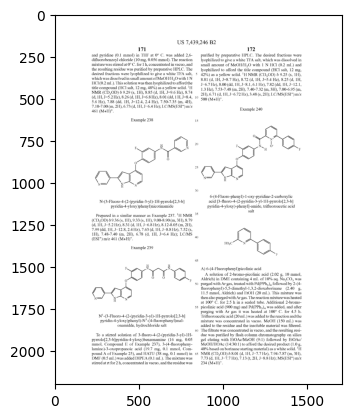

In [21]:
pNum=89
origimage=image=np.array(images[pNum])
plt.imshow(origimage[:,])  #display only the top 400 pixels of the page image

Preprocess the image so that the contour identification routine gets the complete structure.  Gaussian blur on the images encompasses the element labels (such as F, O, N, NH) into the structure.

In [16]:
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #converting image to grayscale
ret,bw_image = cv2.threshold(gray_image, 200, 255, cv2.THRESH_BINARY)
Gaussian = cv2.GaussianBlur(cv2.bitwise_not(gray_image), (19,19), 0)

In [17]:
# Finding Contours
from imutils import contours
cnts, hierarchy = cv2.findContours(Gaussian, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
(cnts, _) = contours.sort_contours(cnts, method="left-to-right")
sorted_contours = sorted(cnts, key=cv2.contourArea, reverse=True)

In [18]:
def get_contour_areas(contours):
    """returns the areas of all contours as list"""
    all_areas = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        all_areas.append(area)
    return all_areas

In [20]:
get_contour_areas(sorted_contours)

[336067.0,
 208883.5,
 165014.0,
 118192.0,
 91287.5,
 46654.0,
 46495.0,
 44733.0,
 38691.0,
 38394.5,
 26791.0,
 19741.0,
 8886.5,
 4370.0,
 4354.0,
 4283.5,
 783.5,
 781.0,
 773.5,
 772.5,
 763.0,
 760.5,
 751.5,
 750.0,
 749.5,
 747.0,
 731.0,
 479.5]

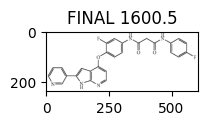

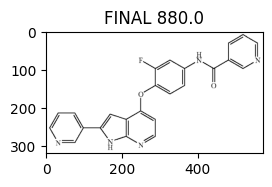

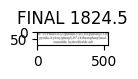

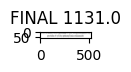

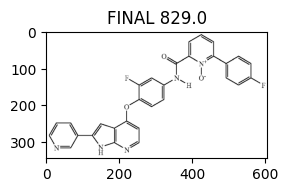

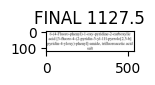

In [ ]:
# Create a mask for the selected contour
mask = np.zeros_like(gray_image)
for e, cnt in enumerate(cnts):
    area = cv2.contourArea(cnt)
    if (area > 20000 and area < 50000):
        cv2.drawContours(mask, [cnt], -1, 255, thickness=cv2.FILLED)
        extracted=cv2.bitwise_not(cv2.bitwise_and(cv2.bitwise_not(gray_image), mask))
        #imshow(extracted, 'Extracted')
        # Crop the bounding rectangle of the contour (optional)
        x, y, w, h = cv2.boundingRect(cnt)
        cropped_roi = extracted[y:y+h, x:x+w]
        imshow( cropped_roi, 'FINAL ' + str(y+0.5*h), 5)
        cv2.imwrite('struct_%03d_%.0f.png' % (pNum, y+0.5*h), cropped_roi)